In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from pathlib import Path
from pprint import pprint

import lerobot
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.datasets.factory import make_dataset


from hydra import compose, initialize
from omegaconf import OmegaConf

# context initialization
with initialize(version_base=None, config_path="../configs", job_name="test_app"):
    cfg = compose(config_name="default")
    print(OmegaConf.to_yaml(cfg))

resume: false
device: cuda
use_amp: false
seed: 100000
dataset_repo_id: lerobot/pusht
video_backend: pyav
training:
  offline_steps: 200000
  num_workers: 4
  batch_size: 64
  eval_freq: 10000
  log_freq: 200
  save_checkpoint: true
  save_freq: 100000
  online_steps: 0
  online_rollout_n_episodes: 1
  online_rollout_batch_size: 1
  online_steps_between_rollouts: 1
  online_sampling_ratio: 0.5
  online_env_seed: null
  online_buffer_capacity: null
  online_buffer_seed_size: 0
  do_online_rollout_async: false
  image_transforms:
    enable: false
    max_num_transforms: 3
    random_order: false
    brightness:
      weight: 1
      min_max:
      - 0.8
      - 1.2
    contrast:
      weight: 1
      min_max:
      - 0.8
      - 1.2
    saturation:
      weight: 1
      min_max:
      - 0.5
      - 1.5
    hue:
      weight: 1
      min_max:
      - -0.05
      - 0.05
    sharpness:
      weight: 1
      min_max:
      - 0.8
      - 1.2
  grad_clip_norm: 10
  lr: 0.0001
  lr_scheduler: 

In [35]:
# get the path to the dataset
import pandas as pd
import numpy as np
from pathlib import Path
env_name = 'ros' # 'pusht' # 'pinpad' # 'robosuite'

# base_path = Path(f"~/workspace/lerobot/local/{env_name}/original").expanduser()
# base_path = Path(f"~/workspace/fastrl/logs/HD_pinpad_four_1/a").expanduser()
imi = 54
AI = False
tdmpc = False
USE_BOTTOM_IMAGE = True

def get_files(env_name, imi, AI=False, tdmpc=False, resize=False):
    if tdmpc:
        bp = f"~/workspace/fastrl/logs/demonstrations/TDMPC_pusht_HD_{imi}_sparse/"
        od = f"~/workspace/lerobot/local/{env_name}/tdmpc{imi}"
        assert not AI
    else:    
        if AI:
            bp = f"~/workspace/fastrl/logs/AD_pusht_{imi}/"
            od = f"~/workspace/lerobot/local/{env_name}/A{imi}"
        else:
            bp = f"~/workspace/fastrl/logs/HD_ros_{imi}/"
            od = f"~/workspace/lerobot/local/{env_name}/{imi}"

    if resize:
        od = od + "_96x96"

    base_path = Path(bp).expanduser()
    out_dir = Path(od).expanduser()

    # print(base_path)
# list all the files in the dataset
    folders = list(base_path.glob("*"))

    files = []
    for f in folders:
        if not str(f).endswith("eps"): continue # only grab demonstrations
        files.extend((base_path / f).glob("*"))
    return files, out_dir

files, out_dir = get_files(env_name, imi, AI=AI, tdmpc=tdmpc)

print(files)

# print the keys
data = np.load(files[0])
# convert to a dictionary NOTE: this is necessary to make the arrays writeable for some reason
data = dict(data)
for k,v in data.items():
    print(k, v.shape)

# print("Setting last is_terminal to true")
# data["is_terminal"][-1] = True; data['is_last'][-1] = True

[PosixPath('/home/j/workspace/fastrl/logs/HD_ros_54/eps/257_pp_pp.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_ros_54/eps/304_pp_pp.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_ros_54/eps/237_pp_pp.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_ros_54/eps/253_pp_pp.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_ros_54/eps/269_pp_pp.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_ros_54/eps/132_pp_pp.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_ros_54/eps/275_pp_pp.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_ros_54/eps/143_pp_pp.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_ros_54/eps/121_pp_pp.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_ros_54/eps/329_pp_pp.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_ros_54/eps/128_pp_pp.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_ros_54/eps/240_pp_pp.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_ros_54/eps/176_pp_pp.npz'), PosixPath('/home/j/workspace/fastrl/logs/HD_ros_54/eps/303_pp_p

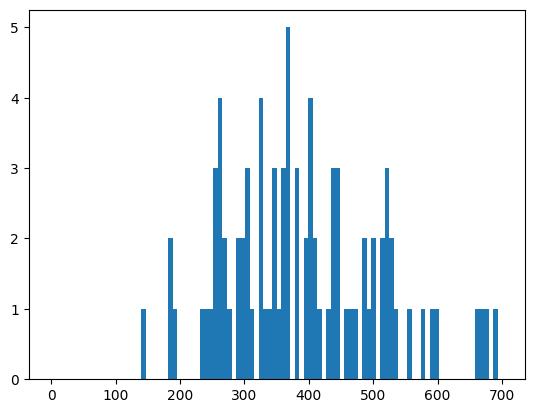

In [36]:

successful_runs_lengths = []
for f in files:
    # read, convert to a dictionary NOTE: this is necessary to make the arrays writeable for some reason
    data = np.load(f); data = dict(data)

    # print(len(data['image_top']), np.sum([entry for entry in data['reward'] if entry > 0]), data['reward'][-1])

    if data['reward'][-1] > 0:
        successful_runs_lengths.append(len(data['reward']) - 1)

import matplotlib.pyplot as plt
plt.hist(successful_runs_lengths, bins=100, range=(0, 700))

CUTOFF = 450

In [37]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
import shutil
repo_id = f"j/{imi}"
root = Path(f'~/workspace/lerobot/local/ros_{imi}_{CUTOFF}{"_BOT" if USE_BOTTOM_IMAGE else ""}').expanduser()
# root.mkdir(exist_ok=True)
shutil.rmtree(root, ignore_errors=True)

use_videos = True

# h, w, ch = data['image_top'][0].shape
img_shape = data['image_top'][0].shape
ch = 3
h, w = img_shape[:2]

state_ndims = data['state'][0].shape[0]
action_ndims = data['action'][0].shape[0]

print(h, w, ch, state_ndims, action_ndims)

features = {
    "observation.image.top": {
        "dtype": "video" if use_videos else "image",
        "shape": [h, w, ch],
        "names": ['height', 'width', 'channels'],
        "info": None},
    "observation.state": {
        "dtype": "float32",
        "shape": (state_ndims,),
        "names": [f's{i}' for i in range(state_ndims)],
    },
    "action": {
        "dtype": "float32",
        "shape": (action_ndims,),
        "names": [f'a{i}' for i in range(action_ndims)],
    },
    "next.reward": {
        "dtype": "float32",
        "shape": (1,),
        "names": None,
    },
    "next.success": {
        "dtype": "bool",
        "shape": (1,),
        "names": None,
    },
}

if USE_BOTTOM_IMAGE:
    features["observation.image.bottom"] = {
        "dtype": "video" if use_videos else "image",
        "shape": [h, w, ch],
        "names": ['height', 'width', 'channels'],
        "info": None}

# metadata = LeRobotDatasetMetadata(repo_id, root, local_files_only=True)
dataset = LeRobotDataset.create(
    repo_id,
    fps=10, # from pusht.yaml
    root=root,
    use_videos=use_videos,
    features=features
)

96 96 3 4 5


In [38]:
from lerobot.common.datasets.utils import DEFAULT_FEATURES

mapping = {
    'image_top': 'observation.image.top',
    'state': 'observation.state',
    'action': 'action',
    'reward': 'next.reward',
}

if USE_BOTTOM_IMAGE:
    mapping['image_bottom'] = 'observation.image.bottom'


for f in files:
    # read, convert to a dictionary NOTE: this is necessary to make the arrays writeable for some reason
    data = np.load(f); data = dict(data)

    if len(data['image_top']) > CUTOFF:
        print(f"Skipping {f} due to length {len(data['image_top'])}")
        continue

    nsteps = len(data['image_top'])
    for t in range(nsteps):
        frame = {}
        for local_key, lerobot_key in mapping.items():
            if "image" in lerobot_key:
                # expand the grayscale image to 3 channels
                img = data[local_key][t]
                if len(img.shape) == 2:
                    img = np.stack([img]*3, axis=-1)
                frame[lerobot_key] = img
            else:
                frame[lerobot_key] = data[local_key][t]
            # if local_key == 'action': 
                # frame[lerobot_key] = (frame[lerobot_key] + 1.) * 256 # NOTE: specifically for gym-pusht


        frame['next.success'] = data['reward'][t] > 0
        dataset.add_frame(frame)

    dataset.save_episode("Pick up a cup.", encode_videos=False)
dataset.consolidate()
dataset.meta.stats['action']


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1648.06ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/304_pp_pp.npz due to length 595


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1707.08ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/269_pp_pp.npz due to length 1454
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/132_pp_pp.npz due to length 519


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1858.35ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/143_pp_pp.npz due to length 1265


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1621.30ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/128_pp_pp.npz due to length 457
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/240_pp_pp.npz due to length 461
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/176_pp_pp.npz due to length 671
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/303_pp_pp.npz due to length 664


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1478.43ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/256_pp_pp.npz due to length 600


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1798.59ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/306_pp_pp.npz due to length 726


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1918.71ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/164_pp_pp.npz due to length 512


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1019.77ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/160_pp_pp.npz due to length 485


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1590.56ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/267_pp_pp.npz due to length 526


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1665.73ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/319_pp_pp.npz due to length 743
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/331_pp_pp.npz due to length 789
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/274_pp_pp.npz due to length 539


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1691.93ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/238_pp_pp.npz due to length 810


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1662.43ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/250_pp_pp.npz due to length 983


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1807.89ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/279_pp_pp.npz due to length 529


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1882.54ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/125_pp_pp.npz due to length 1239
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/330_pp_pp.npz due to length 754


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1893.59ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/167_pp_pp.npz due to length 556


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1794.74ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/161_pp_pp.npz due to length 467


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1599.05ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/245_pp_pp.npz due to length 922


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1620.67ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/148_pp_pp.npz due to length 968
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/175_pp_pp.npz due to length 581


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1599.66ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/239_pp_pp.npz due to length 688


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1820.44ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/156_pp_pp.npz due to length 1549
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/286_pp_pp.npz due to length 944
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/247_pp_pp.npz due to length 515
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/328_pp_pp.npz due to length 733
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/265_pp_pp.npz due to length 850
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/332_pp_pp.npz due to length 678
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/333_pp_pp.npz due to length 1092
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/138_pp_pp.npz due to length 877
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/299_pp_pp.npz due to length 789
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/246_pp_pp.npz due to length 709


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1880.85ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/171_pp_pp.npz due to length 519


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1472.72ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/316_pp_pp.npz due to length 499


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1833.17ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/321_pp_pp.npz due to length 474
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/266_pp_pp.npz due to length 493


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1833.98ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/113_pp_pp.npz due to length 1141
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/137_pp_pp.npz due to length 501
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/309_pp_pp.npz due to length 486


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1741.10ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/260_pp_pp.npz due to length 513
Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/249_pp_pp.npz due to length 839


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1758.62ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/139_pp_pp.npz due to length 525


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1804.78ba/s]


Skipping /home/j/workspace/fastrl/logs/HD_ros_54/eps/248_pp_pp.npz due to length 847


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1743.27ba/s]
Generating train split: 21446 examples [00:00, 683606.88 examples/s]


WARN: We should be using libsvtav1 for fast encode/decode but JSS is lazy. Change for real implementations.
WARN: We should be using libsvtav1 for fast encode/decode but JSS is lazy. Change for real implementations.
WARN: We should be using libsvtav1 for fast encode/decode but JSS is lazy. Change for real implementations.
WARN: We should be using libsvtav1 for fast encode/decode but JSS is lazy. Change for real implementations.
WARN: We should be using libsvtav1 for fast encode/decode but JSS is lazy. Change for real implementations.
WARN: We should be using libsvtav1 for fast encode/decode but JSS is lazy. Change for real implementations.
WARN: We should be using libsvtav1 for fast encode/decode but JSS is lazy. Change for real implementations.
WARN: We should be using libsvtav1 for fast encode/decode but JSS is lazy. Change for real implementations.
WARN: We should be using libsvtav1 for fast encode/decode but JSS is lazy. Change for real implementations.
WARN: We should be using lib

Compute std: 100%|█████████▉| 2680/2681 [00:29<00:00, 89.64it/s] 


{'mean': tensor([ 0.0548, -0.0284,  0.0218,  0.0056,  0.0224]),
 'std': tensor([0.3710, 0.3598, 0.2816, 0.1400, 0.2204]),
 'max': tensor([0.9000, 0.9000, 0.9000, 0.9000, 0.9000]),
 'min': tensor([-0.9000, -0.9000, -0.9000, -0.9000, -0.9000])}

In [39]:
src = root
dst = f'~/.cache/huggingface/hub/datasets--ros_{imi}_{CUTOFF}{"" if not USE_BOTTOM_IMAGE else "_BOT"}'
dst = Path(dst).expanduser()

if Path(dst).exists():
    shutil.rmtree(dst)
shutil.copytree(src, dst)

PosixPath('/home/j/.cache/huggingface/hub/datasets--ros_54_450_BOT')

In [6]:
import tqdm
import torch
import einops
import shutil
from PIL import Image as PILImage
import cv2

from lerobot.common.datasets.push_dataset_to_hub.utils import concatenate_episodes, save_images_concurrently
from lerobot.common.datasets.compute_stats import compute_stats
from lerobot.scripts.push_dataset_to_hub import save_meta_data
from lerobot.common.datasets.video_utils import VideoFrame, encode_video_frames
from lerobot.common.datasets.utils import orhf_transform_to_torch
from datasets import Dataset, Features, Image, Sequence, Value

def to_hf_dataset(data_dict, video):
    features = {}

    if video:
        features["observation.image"] = VideoFrame()
    else:
        features["observation.image"] = Image()

    features["observation.state"] = Sequence(
        length=data_dict["observation.state"].shape[1], feature=Value(dtype="float32", id=None)
    )
    features["action"] = Sequence(
        length=data_dict["action"].shape[1], feature=Value(dtype="float32", id=None)
    )
    features["episode_index"] = Value(dtype="int64", id=None)
    features["frame_index"] = Value(dtype="int64", id=None)
    features["timestamp"] = Value(dtype="float32", id=None)
    features["next.reward"] = Value(dtype="float32", id=None)
    features["next.done"] = Value(dtype="bool", id=None)
    features["index"] = Value(dtype="int64", id=None)
    # TODO(rcadene): add success
    # features["next.success"] = Value(dtype='bool', id=None)

    hf_dataset = Dataset.from_dict(data_dict, features=Features(features))
    hf_dataset.set_transform(hf_transform_to_torch)
    return hf_dataset

def files_to_data_dict(files):
    data_dicts = []
    for data_fn in files:
        print(f"Processing {data_fn}", end='...')
        data = np.load(data_fn)
        data = dict(data); 
        data["is_terminal"][-1] = True
        data_dicts.append(data)
    print()
    big_data_dict = {}
    for k in data_dicts[0].keys():
        big_data_dict[k] = np.concatenate([d[k] for d in data_dicts], axis=0)
        print(k, big_data_dict[k].shape)
        # if 'reward' in big_data_dict:
        #     for kk in ['reward', 'is_terminal', 'is_last']:
        #         print(f"\t{kk} {sum(big_data_dict[kk])}", end='  ')
    return big_data_dict

# big_data_dict = files_to_data_dict(files)

In [7]:
def fastrl_to_hf(big_data_dict, out_dir):
    video = False; fps = 10; video_path = None; debug = False
    ep_dicts = []
    episode_data_index = {"from": [], "to": []}

    id_from = 0
    id_to = 0
    ep_idx = 0
    data = big_data_dict
    total_frames = data["action"].shape[0]
# for i in tqdm.tqdm(range(total_frames)):
    for i in range(total_frames):
        id_to += 1

        if not data["is_terminal"][i]:
            continue

    # print("found terminal step")

        num_frames = id_to - id_from

        image = torch.tensor(data["image"][id_from:id_to])
    # image = einops.rearrange(image, "b h w c -> b h w c")
    # image = einops.rearrange(image, "b c h w -> b h w c")
        state = torch.tensor(data["state"][id_from:id_to, :2]) if ("state" in data) else torch.zeros(num_frames, 1)
    # state = torch.tensor(data["vector_state"][id_from:id_to]) if ("vector_state" in data) else torch.zeros(num_frames, 1)
        action = (torch.tensor(data["action"][id_from:id_to]) + 1) * 256
    # action = torch.tensor(data["action"][id_from:id_to])
    # TODO(rcadene): we have a missing last frame which is the observation when the env is done
    # it is critical to have this frame for tdmpc to predict a "done observation/state"
    # next_image = torch.tensor(data["next_observations"]["rgb"][id_from:id_to])
    # next_state = torch.tensor(data["next_observations"]["state"][id_from:id_to])
        next_reward = torch.tensor(data["reward"][id_from:id_to])
        next_done = torch.tensor(data["is_terminal"][id_from:id_to])

        ep_dict = {}

        imgs_array = [x.numpy() for x in image]
        img_key = "observation.image"
        if video:
        # save png images in temporary directory
            tmp_imgs_dir = out_dir / "tmp_images"
            tmp_imgs_dir.mkdir(parents=True, exist_ok=True)

            for i in range(len(imgs_array)):
                img = PILImage.fromarray(imgs_array[i])
                img.save(str(tmp_imgs_dir / f"frame_{i:06d}.png"), quality=100)

        # encode images to a mp4 video
            fname = f"{img_key}_episode_{ep_idx:06d}.mp4"
            video_path = out_dir / "videos" / fname
            encode_video_frames(tmp_imgs_dir, video_path, fps)

        # clean temporary images directory
            shutil.rmtree(tmp_imgs_dir)

        # store the reference to the video frame
            ep_dict[img_key] = [{"path": f"videos/{fname}", "timestamp": i / fps} for i in range(num_frames)]
        else:
        # ep_dict[img_key] = [PILImage.fromarray(x) for x in imgs_array]
            ep_dict[img_key] = imgs_array

        ep_dict["observation.state"] = state
        ep_dict["action"] = action
        ep_dict["episode_index"] = torch.tensor([ep_idx] * num_frames, dtype=torch.int64)
        ep_dict["frame_index"] = torch.arange(0, num_frames, 1)
        ep_dict["timestamp"] = torch.arange(0, num_frames, 1) / fps
    # ep_dict["next.observation.image"] = next_image
    # ep_dict["next.observation.state"] = next_state
        ep_dict["next.reward"] = next_reward
        ep_dict["next.done"] = next_done
        ep_dicts.append(ep_dict)

        episode_data_index["from"].append(id_from)
        episode_data_index["to"].append(id_from + num_frames)

        id_from = id_to
        ep_idx += 1

    # process first episode only
        if debug:
            break
    if len(ep_dicts) == 0:
        print("No terminal step found in the dataset")
    else:
        for k,v in ep_dicts[0].items():
            print(k, ep_dicts[0][k].shape if hasattr(ep_dicts[0][k], 'shape') else len(ep_dicts[0][k]), ep_dicts[-1][k].shape if hasattr(ep_dicts[-1][k], 'shape') else len(ep_dicts[-1][k]))

        # convert things to
        data_dict = concatenate_episodes(ep_dicts)
        data_dict, episode_data_index

        for k,v in data_dict.items():
            print(k, v.shape if hasattr(v, 'shape') else len(v), type(v))

        hf_dataset = to_hf_dataset(data_dict, video)

        info = {"fps": fps, "video": video}

        if video_path: 
            print(f"video path: {video_path}")
        lerobot_dataset = LeRobotDataset.from_preloaded(
            repo_id=env_name,
            hf_dataset=hf_dataset,
            episode_data_index=episode_data_index,
            info=info,
            videos_dir=video_path,
            )


        hf_dataset = hf_dataset.with_format(None)  # to remove transforms that cant be saved
        hf_dataset.save_to_disk(str(out_dir / "train"))
    # print(lerobot_dataset)
    stats = compute_stats(lerobot_dataset, batch_size=16, num_workers=1)
    save_meta_data(info, stats, episode_data_index, out_dir / "meta_data")
    return stats

# stats = fastrl_to_hf(big_data_dict, out_dir)


In [8]:
import cv2
import numpy as np

def resize_images(bdd):
    for k in ['pixels', 'image']:
        if k in bdd:
            print(f"Original {k} shape:", bdd[k].shape)

            # Reshape if necessary (assuming the images are in NHWC format)
            if bdd[k].shape[-1] != 3:
                bdd[k] = np.transpose(bdd[k], (0, 2, 3, 1))
        
            # Get the original dimensions
            n, h, w, c = bdd[k].shape
        
            # Resize to 96x96
            resized = np.zeros((n, 96, 96, c), dtype=bdd[k].dtype)
            for i in range(n):
                resized[i] = cv2.resize(bdd[k][i], (96, 96), interpolation=cv2.INTER_CUBIC)
        
        # Update the dictionary with resized images
            bdd[k] = resized
            
            print(f"Resized {k} shape:", bdd[k].shape)
    else:
        print(f"Key '{k}' not found in big_data_dict")

In [ ]:
# imis = [4, 5, 6, 7, 9, 10] if AI else [3,4,5,6,7,8,9,10]
RESIZE_TO_96x96 = False
imis = [22] #[11, 12, 13, 14]
for ai_tag in [True, False]:
    for imi in imis:
        files, out_dir = get_files(env_name, imi, AI=ai_tag, resize=RESIZE_TO_96x96)
        if files:
            big_data_dict = files_to_data_dict(files)
            if RESIZE_TO_96x96: resize_images(big_data_dict)
            print(f"Attempting to write to {out_dir}")
            stats = fastrl_to_hf(big_data_dict, out_dir)
            # for k,v in stats.items():
            #     print(k, v)
        else: print(f"Could not find files for {imi} AI {ai_tag}")

In [ ]:
video = False; fps = 20; video_path = None; debug = False
ep_dicts = []
episode_data_index = {"from": [], "to": []}

id_from = 0
id_to = 0
ep_idx = 0
data = big_data_dict
total_frames = data["action"].shape[0]
# for i in tqdm.tqdm(range(total_frames)):
for i in range(total_frames):
    id_to += 1

    if not data["is_terminal"][i]:
        continue

# print("found terminal step")

    num_frames = id_to - id_from

    image = torch.tensor(data["image"][id_from:id_to])
# image = einops.rearrange(image, "b h w c -> b h w c")
# image = einops.rearrange(image, "b c h w -> b h w c")
    state = torch.tensor(data["state"][id_from:id_to, :2]) if ("state" in data) else torch.zeros(num_frames, 1)
# state = torch.tensor(data["vector_state"][id_from:id_to]) if ("vector_state" in data) else torch.zeros(num_frames, 1)
    action = (torch.tensor(data["action"][id_from:id_to]) + 1) * 256
# action = torch.tensor(data["action"][id_from:id_to])
# TODO(rcadene): we have a missing last frame which is the observation when the env is done
# it is critical to have this frame for tdmpc to predict a "done observation/state"
# next_image = torch.tensor(data["next_observations"]["rgb"][id_from:id_to])
# next_state = torch.tensor(data["next_observations"]["state"][id_from:id_to])
    next_reward = torch.tensor(data["reward"][id_from:id_to])
    next_done = torch.tensor(data["is_terminal"][id_from:id_to])

    ep_dict = {}

    imgs_array = [x.numpy() for x in image]
    img_key = "observation.image"
    if video:
    # save png images in temporary directory
        tmp_imgs_dir = out_dir / "tmp_images"
        tmp_imgs_dir.mkdir(parents=True, exist_ok=True)

        for i in range(len(imgs_array)):
            img = PILImage.fromarray(imgs_array[i])
            img.save(str(tmp_imgs_dir / f"frame_{i:06d}.png"), quality=100)

    # encode images to a mp4 video
        fname = f"{img_key}_episode_{ep_idx:06d}.mp4"
        video_path = out_dir / "videos" / fname
        encode_video_frames(tmp_imgs_dir, video_path, fps)

    # clean temporary images directory
        shutil.rmtree(tmp_imgs_dir)

    # store the reference to the video frame
        ep_dict[img_key] = [{"path": f"videos/{fname}", "timestamp": i / fps} for i in range(num_frames)]
    else:
    # ep_dict[img_key] = [PILImage.fromarray(x) for x in imgs_array]
        ep_dict[img_key] = imgs_array

    ep_dict["observation.state"] = state
    ep_dict["action"] = action
    ep_dict["episode_index"] = torch.tensor([ep_idx] * num_frames, dtype=torch.int64)
    ep_dict["frame_index"] = torch.arange(0, num_frames, 1)
    ep_dict["timestamp"] = torch.arange(0, num_frames, 1) / fps
# ep_dict["next.observation.image"] = next_image
# ep_dict["next.observation.state"] = next_state
    ep_dict["next.reward"] = next_reward
    ep_dict["next.done"] = next_done
    ep_dicts.append(ep_dict)

    episode_data_index["from"].append(id_from)
    episode_data_index["to"].append(id_from + num_frames)

    id_from = id_to
    ep_idx += 1

# process first episode only
    if debug:
        break
if len(ep_dicts) == 0:
    print("No terminal step found in the dataset")
else:
    for k,v in ep_dicts[0].items():
        print(k, ep_dicts[0][k].shape if hasattr(ep_dicts[0][k], 'shape') else len(ep_dicts[0][k]), ep_dicts[-1][k].shape if hasattr(ep_dicts[-1][k], 'shape') else len(ep_dicts[-1][k]))

    # convert things to
    data_dict = concatenate_episodes(ep_dicts)

In [ ]:
ep_dicts[0]['observation.image'][0].shape


for f,t in zip(episode_data_index['from'], episode_data_index['to']):
    print(f, t, data_dict['action'][f:t].shape)